### Simulated Heavy-Ion Collisions with a Generative Adversarial Network

Certain physics models to describe the initially deposited energy density in heavy-ion collisions can be computationally demanding, with the generation of a single event exceeding several core hours. 

These notebooks explore the use of Generative Adversarial Networks (GAN) as a fast and approximate surrogate to model the collision initial conditions. 

Please see this page for a useful introduction to GANs: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/ and https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/ for Wasserstein GANs.

### Before running this notebook, one needs to download the event files.
These occupy quite a bit of space and can not be stored on github. 

Please execute `sh prepare.sh` exactly once before running this analysis notebook. 

In [1]:
#! sh prepare.sh #it will take quite a few minutes to download and decompress the events

The downloaded profiles are stored in the `training_profiles` directory.

They have a format which can be read using the function defined below.

Any work which makes reference to this notebook should cite the authors/generators of the profiles:

B. Schenke, P. Tribedy, R. Venugopalan, Fluctuating Glasma Initial Conditions and Flow in Heavy Ion Collisions
Phys. Rev. Lett. 108, 252301 (2012)

B. Schenke, P. Tribedy, R. Venugopalan
Event-by-event gluon multiplicity, energy density, and eccentricities in ultrarelativistic heavy-ion collisions
Phys. Rev. C86, 034908 (2012)

Please see https://quark.phy.bnl.gov/~bschenke/ipglasma-doc.txt for the documentation. 

We begin by importing some necessary libraries...

In [2]:
#Begin by importing some necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()
sns.set_context('talk')
sns.set_style("darkgrid", {'axes.grid' : False})

The cell below defines a function to read in each profile from disk.

In [3]:
header_list = ['eta', 'x', 'y', 'eps', 'ut', 'ux', 'uy', 'T00', 'T0x', 'T0y', 'T0eta'] 
nx = ny = 200 # the number of pixels (gridpoints) in x and y
dx = dy = 0.17 # the size of each pixel in fm = 10^{-15} m
n_profiles = 3970 # the number of profiles

# the factor by which we coarse-grain.
# profiles should probably only be coarse-grained for testing/debugging purposes
n_coarse = 1
# the number of pixels to clip off edges
n_clip = 44 

def load_ipglasma_profile(i):
    """A function to read in a single ipglasma event profile from disk"""
    df = pd.read_csv('training_profiles/PbPb0-10/epsilon-u-Hydro'+str(i)+'.dat', header=None, 
                 sep=' ', skiprows=1, names=header_list)
    eps = df['eps'].values.reshape(nx, ny)[n_clip:-n_clip:n_coarse, n_clip:-n_clip:n_coarse]
    return eps

Let's visualize a randomly selected energy density profile.

/usr/local/anaconda5/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  """


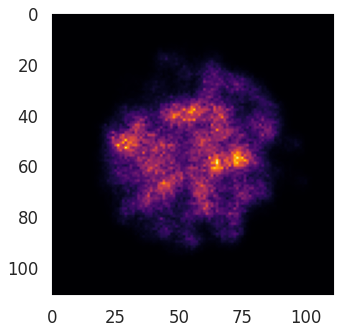

In [4]:
i = np.random.randint(0, high=n_profiles, size=1, dtype='l')[0]
eps = load_ipglasma_profile(i) # the loaded profile
fig, axes = plt.subplots(1,1, figsize=(5,5))
plt.imshow(eps, cmap='inferno')
plt.tight_layout(True)
plt.show()

Typically machine learning models will expect the inputs to be of 'natural' size, not too much smaller or larger than 1. 

Therefore, we will first rescale all of the profiles from $(0, \epsilon_{\rm max}) \rightarrow (0, 1)$.

The choice of the scaling function may be important in the accuracy of the resulting model, and should likely be explored.

In [5]:
rescale_a = 1.
def eps_rescaling_fct(eps_profile, eps_max):
    """Function to rescale the energy density profile to [-1,1]"""
    # a linear rescaling
    #return 2.* eps_profile / eps_max - np.ones_like(eps_profile)
    # perhaps non-linear rescaling works better
    #return eps_profile / (rescale_a*np.ones_like(eps_profile) + eps_profile)
    #do nothing
    return eps_profile

def inv_eps_rescaling_fct(eps_profile, eps_max):
    """Function to invert rescaling of energy density profile to [0, eps_max]"""
    # a linear rescaling
    #return (eps_profile + np.ones_like(eps_profile)) / 2. * eps_max
    # perhaps non-linear rescaling works better
    #return eps_profile / (rescale_a*np.ones_like(eps_profile) - eps_profile)
    #do nothing
    return eps_profile

In [6]:
def global_scaler(X):
    scale = X.max()
    X = 2.*X/scale - 1.
    return X, scale

Additionally, there is strong evidence that the soft observables in heavy ion collisions are insensitive to small scale geometrical features (features of the order of the pixel size $0.15 $ fm ). Concordantly, to improve the behavior and learning of our model, we will first apply a Gaussian smoothing filter to each training profile. Refs. (https://inspirehep.net/literature/1387518, https://arxiv.org/pdf/1712.03912.pdf) 


The cell below will iteratively load each profile from disk, apply a Guassian filter to smoothen it, then rescale it, and append it to a training array. 

In [7]:
from skimage import filters
# this cell will load each profile from disk, rescale it, apply a smoothing filter
# and append it to the training array

reload_training_profiles = False
sigma_filter = 2 # the pixel size of the Gauss. filter std. dev.
if reload_training_profiles:
    trainX = [] # array of all training images
    for i in range(1, n_profiles+1):
    #for i in range(1, 100):
        eps_profile = load_ipglasma_profile(i) #load profile
        #eps_scaled = eps_rescaling_fct(eps_profile, eps_max) #rescale 
        eps_scaled = eps_profile
        eps_smooth = filters.gaussian(eps_scaled, 
                                              sigma=sigma_filter, 
                                              preserve_range=True) #smoothen 
        
        trainX.append(eps_smooth) #append to training array
    
    trainX = np.array(trainX) #np arrays are nicer
    trainX, eps_max = global_scaler(trainX)
    print(trainX.shape)
    #save the training data to disk, for later convenience
    np.save('training_profiles/trainX', trainX)
    np.save('training_profiles/trainX_eps_max', eps_max)

If the operation above has already been performed previously, the cell above can be skipped and the training array loaded directly from disk. This is much faster, and is performed in the cell below. 

In [8]:
#load the training profiles array from disk (faster)
trainX = np.load('training_profiles/trainX.npy')
eps_max = np.load('training_profiles/trainX_eps_max.npy')
print(trainX.shape)

img_nx = trainX.shape[1] #size of image in x
img_ny = trainX.shape[2] #size of image in x

(3970, 112, 112)


Let's visualize a random profile from the training data. 

Remember, this profile has been smoothened and rescaled with a (perhaps non-linear) scaling function. 

/usr/local/anaconda5/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


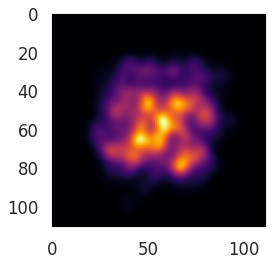

In [9]:
i=np.random.randint(1, high=n_profiles+1, size=1, dtype='l')[0]
plt.imshow(trainX[i], cmap='inferno')
plt.tight_layout(True)
plt.show()

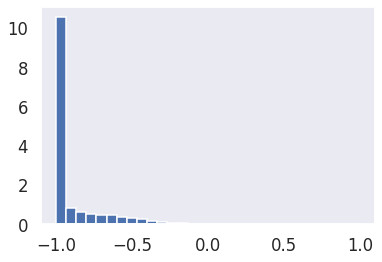

In [10]:
plt.hist(trainX.flatten() , bins=30, density=True)
plt.show()

In [11]:
from wgan import *
my_gan = WGAN()

Using TensorFlow backend.
/users/PAS0254/osu9790/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/PAS0254/osu9790/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/PAS0254/osu9790/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/PAS0254/osu9790/.local/lib/p

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 56, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 56, 56, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 29, 29, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 32)        128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 29, 29, 32)       

In [12]:
my_gan.train(X_train=trainX, epochs=4000, batch_size=32, sample_interval=50)

/users/PAS0254/osu9790/.local/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/users/PAS0254/osu9790/.local/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.999800] [G loss: 1.000499]
(25, 112, 112, 1)
(25, 112, 112, 1)


/users/PAS0254/osu9790/.local/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.999822] [G loss: 1.000523]
2 [D loss: 0.999827] [G loss: 1.000500]
3 [D loss: 0.999835] [G loss: 1.000518]
4 [D loss: 0.999827] [G loss: 1.000515]
5 [D loss: 0.999839] [G loss: 1.000516]
6 [D loss: 0.999835] [G loss: 1.000494]
7 [D loss: 0.999841] [G loss: 1.000474]
8 [D loss: 0.999841] [G loss: 1.000470]
9 [D loss: 0.999832] [G loss: 1.000398]
10 [D loss: 0.999831] [G loss: 1.000399]
11 [D loss: 0.999846] [G loss: 1.000371]
12 [D loss: 0.999852] [G loss: 1.000316]
13 [D loss: 0.999866] [G loss: 1.000266]
14 [D loss: 0.999898] [G loss: 1.000202]
15 [D loss: 0.999915] [G loss: 1.000159]
16 [D loss: 0.999931] [G loss: 1.000118]
17 [D loss: 0.999937] [G loss: 1.000077]
18 [D loss: 0.999947] [G loss: 1.000061]
19 [D loss: 0.999942] [G loss: 1.000045]
20 [D loss: 0.999956] [G loss: 1.000052]
21 [D loss: 0.999959] [G loss: 1.000059]
22 [D loss: 0.999956] [G loss: 1.000052]
23 [D loss: 0.999951] [G loss: 1.000048]
24 [D loss: 0.999956] [G loss: 1.000042]
25 [D loss: 0.999952] [G 

197 [D loss: 0.999920] [G loss: 1.000660]
198 [D loss: 0.999931] [G loss: 1.000646]
199 [D loss: 0.999920] [G loss: 1.000639]
200 [D loss: 0.999917] [G loss: 1.000648]
(25, 112, 112, 1)
(25, 112, 112, 1)
201 [D loss: 0.999907] [G loss: 1.000618]
202 [D loss: 0.999921] [G loss: 1.000607]
203 [D loss: 0.999906] [G loss: 1.000583]
204 [D loss: 0.999921] [G loss: 1.000560]
205 [D loss: 0.999921] [G loss: 1.000557]
206 [D loss: 0.999913] [G loss: 1.000508]
207 [D loss: 0.999918] [G loss: 1.000525]
208 [D loss: 0.999923] [G loss: 1.000506]
209 [D loss: 0.999925] [G loss: 1.000465]
210 [D loss: 0.999928] [G loss: 1.000466]
211 [D loss: 0.999925] [G loss: 1.000443]
212 [D loss: 0.999926] [G loss: 1.000407]
213 [D loss: 0.999915] [G loss: 1.000420]
214 [D loss: 0.999933] [G loss: 1.000410]
215 [D loss: 0.999928] [G loss: 1.000381]
216 [D loss: 0.999922] [G loss: 1.000404]
217 [D loss: 0.999937] [G loss: 1.000382]
218 [D loss: 0.999911] [G loss: 1.000369]
219 [D loss: 0.999918] [G loss: 1.000375

389 [D loss: 0.999954] [G loss: 1.000049]
390 [D loss: 0.999959] [G loss: 1.000055]
391 [D loss: 0.999958] [G loss: 1.000057]
392 [D loss: 0.999951] [G loss: 1.000033]
393 [D loss: 0.999957] [G loss: 1.000056]
394 [D loss: 0.999959] [G loss: 1.000055]
395 [D loss: 0.999954] [G loss: 1.000056]
396 [D loss: 0.999949] [G loss: 1.000043]
397 [D loss: 0.999962] [G loss: 1.000046]
398 [D loss: 0.999954] [G loss: 1.000041]
399 [D loss: 0.999949] [G loss: 1.000046]
400 [D loss: 0.999952] [G loss: 1.000048]
(25, 112, 112, 1)
(25, 112, 112, 1)
401 [D loss: 0.999962] [G loss: 1.000053]
402 [D loss: 0.999959] [G loss: 1.000042]
403 [D loss: 0.999965] [G loss: 1.000053]
404 [D loss: 0.999960] [G loss: 1.000031]
405 [D loss: 0.999952] [G loss: 1.000052]
406 [D loss: 0.999949] [G loss: 1.000051]
407 [D loss: 0.999958] [G loss: 1.000052]
408 [D loss: 0.999962] [G loss: 1.000054]
409 [D loss: 0.999959] [G loss: 1.000055]
410 [D loss: 0.999965] [G loss: 1.000040]
411 [D loss: 0.999962] [G loss: 1.000064

581 [D loss: 0.999954] [G loss: 1.000052]
582 [D loss: 0.999957] [G loss: 1.000053]
583 [D loss: 0.999957] [G loss: 1.000060]
584 [D loss: 0.999954] [G loss: 1.000055]
585 [D loss: 0.999949] [G loss: 1.000059]
586 [D loss: 0.999961] [G loss: 1.000044]
587 [D loss: 0.999952] [G loss: 1.000057]
588 [D loss: 0.999956] [G loss: 1.000054]
589 [D loss: 0.999961] [G loss: 1.000055]
590 [D loss: 0.999962] [G loss: 1.000055]
591 [D loss: 0.999953] [G loss: 1.000064]
592 [D loss: 0.999957] [G loss: 1.000044]
593 [D loss: 0.999956] [G loss: 1.000047]
594 [D loss: 0.999959] [G loss: 1.000057]
595 [D loss: 0.999955] [G loss: 1.000053]
596 [D loss: 0.999948] [G loss: 1.000044]
597 [D loss: 0.999955] [G loss: 1.000051]
598 [D loss: 0.999967] [G loss: 1.000047]
599 [D loss: 0.999959] [G loss: 1.000061]
600 [D loss: 0.999957] [G loss: 1.000061]
(25, 112, 112, 1)
(25, 112, 112, 1)
601 [D loss: 0.999957] [G loss: 1.000058]
602 [D loss: 0.999965] [G loss: 1.000056]
603 [D loss: 0.999954] [G loss: 1.000054

773 [D loss: 0.999965] [G loss: 1.000049]
774 [D loss: 0.999944] [G loss: 1.000061]
775 [D loss: 0.999958] [G loss: 1.000054]
776 [D loss: 0.999961] [G loss: 1.000050]
777 [D loss: 0.999951] [G loss: 1.000052]
778 [D loss: 0.999951] [G loss: 1.000055]
779 [D loss: 0.999963] [G loss: 1.000046]
780 [D loss: 0.999964] [G loss: 1.000048]
781 [D loss: 0.999955] [G loss: 1.000053]
782 [D loss: 0.999957] [G loss: 1.000052]
783 [D loss: 0.999968] [G loss: 1.000058]
784 [D loss: 0.999960] [G loss: 1.000054]
785 [D loss: 0.999963] [G loss: 1.000034]
786 [D loss: 0.999954] [G loss: 1.000047]
787 [D loss: 0.999960] [G loss: 1.000042]
788 [D loss: 0.999962] [G loss: 1.000059]
789 [D loss: 0.999957] [G loss: 1.000058]
790 [D loss: 0.999960] [G loss: 1.000061]
791 [D loss: 0.999954] [G loss: 1.000053]
792 [D loss: 0.999958] [G loss: 1.000054]
793 [D loss: 0.999964] [G loss: 1.000059]
794 [D loss: 0.999959] [G loss: 1.000049]
795 [D loss: 0.999959] [G loss: 1.000054]
796 [D loss: 0.999956] [G loss: 1.

965 [D loss: 0.999958] [G loss: 1.000052]
966 [D loss: 0.999959] [G loss: 1.000054]
967 [D loss: 0.999953] [G loss: 1.000045]
968 [D loss: 0.999956] [G loss: 1.000052]
969 [D loss: 0.999958] [G loss: 1.000045]
970 [D loss: 0.999958] [G loss: 1.000051]
971 [D loss: 0.999950] [G loss: 1.000055]
972 [D loss: 0.999958] [G loss: 1.000063]
973 [D loss: 0.999958] [G loss: 1.000061]
974 [D loss: 0.999956] [G loss: 1.000055]
975 [D loss: 0.999951] [G loss: 1.000052]
976 [D loss: 0.999953] [G loss: 1.000053]
977 [D loss: 0.999952] [G loss: 1.000038]
978 [D loss: 0.999953] [G loss: 1.000051]
979 [D loss: 0.999961] [G loss: 1.000053]
980 [D loss: 0.999956] [G loss: 1.000061]
981 [D loss: 0.999965] [G loss: 1.000052]
982 [D loss: 0.999954] [G loss: 1.000058]
983 [D loss: 0.999958] [G loss: 1.000051]
984 [D loss: 0.999945] [G loss: 1.000049]
985 [D loss: 0.999953] [G loss: 1.000054]
986 [D loss: 0.999965] [G loss: 1.000041]
987 [D loss: 0.999963] [G loss: 1.000054]
988 [D loss: 0.999960] [G loss: 1.

1153 [D loss: 0.999957] [G loss: 1.000042]
1154 [D loss: 0.999964] [G loss: 1.000049]
1155 [D loss: 0.999959] [G loss: 1.000056]
1156 [D loss: 0.999955] [G loss: 1.000057]
1157 [D loss: 0.999961] [G loss: 1.000055]
1158 [D loss: 0.999957] [G loss: 1.000056]
1159 [D loss: 0.999964] [G loss: 1.000054]
1160 [D loss: 0.999954] [G loss: 1.000048]
1161 [D loss: 0.999956] [G loss: 1.000022]
1162 [D loss: 0.999955] [G loss: 1.000051]
1163 [D loss: 0.999962] [G loss: 1.000053]
1164 [D loss: 0.999965] [G loss: 1.000048]
1165 [D loss: 0.999960] [G loss: 1.000048]
1166 [D loss: 0.999957] [G loss: 1.000046]
1167 [D loss: 0.999960] [G loss: 1.000056]
1168 [D loss: 0.999954] [G loss: 1.000049]
1169 [D loss: 0.999960] [G loss: 1.000050]
1170 [D loss: 0.999957] [G loss: 1.000059]
1171 [D loss: 0.999961] [G loss: 1.000044]
1172 [D loss: 0.999961] [G loss: 1.000052]
1173 [D loss: 0.999960] [G loss: 1.000048]
1174 [D loss: 0.999959] [G loss: 1.000062]
1175 [D loss: 0.999962] [G loss: 1.000049]
1176 [D los

1342 [D loss: 0.999946] [G loss: 1.000062]
1343 [D loss: 0.999961] [G loss: 1.000054]
1344 [D loss: 0.999949] [G loss: 1.000048]
1345 [D loss: 0.999963] [G loss: 1.000059]
1346 [D loss: 0.999958] [G loss: 1.000049]
1347 [D loss: 0.999960] [G loss: 1.000049]
1348 [D loss: 0.999953] [G loss: 1.000058]
1349 [D loss: 0.999961] [G loss: 1.000056]
1350 [D loss: 0.999958] [G loss: 1.000050]
(25, 112, 112, 1)
(25, 112, 112, 1)
1351 [D loss: 0.999959] [G loss: 1.000058]
1352 [D loss: 0.999964] [G loss: 1.000053]
1353 [D loss: 0.999953] [G loss: 1.000057]
1354 [D loss: 0.999951] [G loss: 1.000056]
1355 [D loss: 0.999951] [G loss: 1.000058]
1356 [D loss: 0.999956] [G loss: 1.000062]
1357 [D loss: 0.999958] [G loss: 1.000046]
1358 [D loss: 0.999958] [G loss: 1.000055]
1359 [D loss: 0.999964] [G loss: 1.000049]
1360 [D loss: 0.999959] [G loss: 1.000050]
1361 [D loss: 0.999956] [G loss: 1.000052]
1362 [D loss: 0.999963] [G loss: 1.000056]
1363 [D loss: 0.999954] [G loss: 1.000062]
1364 [D loss: 0.99

1530 [D loss: 0.999959] [G loss: 1.000053]
1531 [D loss: 0.999962] [G loss: 1.000054]
1532 [D loss: 0.999960] [G loss: 1.000059]
1533 [D loss: 0.999962] [G loss: 1.000047]
1534 [D loss: 0.999959] [G loss: 1.000051]
1535 [D loss: 0.999960] [G loss: 1.000053]
1536 [D loss: 0.999960] [G loss: 1.000059]
1537 [D loss: 0.999952] [G loss: 1.000051]
1538 [D loss: 0.999959] [G loss: 1.000059]
1539 [D loss: 0.999955] [G loss: 1.000040]
1540 [D loss: 0.999959] [G loss: 1.000055]
1541 [D loss: 0.999954] [G loss: 1.000062]
1542 [D loss: 0.999958] [G loss: 1.000057]
1543 [D loss: 0.999952] [G loss: 1.000057]
1544 [D loss: 0.999959] [G loss: 1.000048]
1545 [D loss: 0.999963] [G loss: 1.000046]
1546 [D loss: 0.999963] [G loss: 1.000061]
1547 [D loss: 0.999960] [G loss: 1.000055]
1548 [D loss: 0.999954] [G loss: 1.000055]
1549 [D loss: 0.999960] [G loss: 1.000060]
1550 [D loss: 0.999957] [G loss: 1.000055]
(25, 112, 112, 1)
(25, 112, 112, 1)
1551 [D loss: 0.999953] [G loss: 1.000045]
1552 [D loss: 0.99

1718 [D loss: 0.999965] [G loss: 1.000050]
1719 [D loss: 0.999963] [G loss: 1.000055]
1720 [D loss: 0.999960] [G loss: 1.000035]
1721 [D loss: 0.999957] [G loss: 1.000042]
1722 [D loss: 0.999959] [G loss: 1.000057]
1723 [D loss: 0.999958] [G loss: 1.000064]
1724 [D loss: 0.999967] [G loss: 1.000032]
1725 [D loss: 0.999956] [G loss: 1.000049]
1726 [D loss: 0.999961] [G loss: 1.000048]
1727 [D loss: 0.999957] [G loss: 1.000050]
1728 [D loss: 0.999956] [G loss: 1.000052]
1729 [D loss: 0.999950] [G loss: 1.000057]
1730 [D loss: 0.999960] [G loss: 1.000048]
1731 [D loss: 0.999948] [G loss: 1.000045]
1732 [D loss: 0.999955] [G loss: 1.000051]
1733 [D loss: 0.999956] [G loss: 1.000050]
1734 [D loss: 0.999950] [G loss: 1.000038]
1735 [D loss: 0.999955] [G loss: 1.000048]
1736 [D loss: 0.999959] [G loss: 1.000061]
1737 [D loss: 0.999956] [G loss: 1.000049]
1738 [D loss: 0.999960] [G loss: 1.000058]
1739 [D loss: 0.999957] [G loss: 1.000060]
1740 [D loss: 0.999956] [G loss: 1.000064]
1741 [D los

1906 [D loss: 0.999952] [G loss: 1.000049]
1907 [D loss: 0.999951] [G loss: 1.000045]
1908 [D loss: 0.999954] [G loss: 1.000038]
1909 [D loss: 0.999950] [G loss: 1.000061]
1910 [D loss: 0.999949] [G loss: 1.000051]
1911 [D loss: 0.999957] [G loss: 1.000053]
1912 [D loss: 0.999956] [G loss: 1.000053]
1913 [D loss: 0.999960] [G loss: 1.000052]
1914 [D loss: 0.999951] [G loss: 1.000049]
1915 [D loss: 0.999965] [G loss: 1.000059]
1916 [D loss: 0.999956] [G loss: 1.000055]
1917 [D loss: 0.999952] [G loss: 1.000054]
1918 [D loss: 0.999953] [G loss: 1.000059]
1919 [D loss: 0.999960] [G loss: 1.000057]
1920 [D loss: 0.999962] [G loss: 1.000056]
1921 [D loss: 0.999959] [G loss: 1.000049]
1922 [D loss: 0.999966] [G loss: 1.000044]
1923 [D loss: 0.999966] [G loss: 1.000037]
1924 [D loss: 0.999963] [G loss: 1.000039]
1925 [D loss: 0.999964] [G loss: 1.000040]
1926 [D loss: 0.999960] [G loss: 1.000062]
1927 [D loss: 0.999958] [G loss: 1.000059]
1928 [D loss: 0.999962] [G loss: 1.000052]
1929 [D los

KeyboardInterrupt: 